Introduction:

A research group at UBC is collecting data about how people play video games. They created a MineCraft server and recorded each player’s data. This group is interested in what player characteristics are most predictive of subscribing to a game-related newsletter. The player data includes a broad set of variables that reflect their characteristics. For this project, I have limited the player variables to be their age and the number of hours played on the server to find out whether those characteristics specifically are indicative of whether or not the players will be subscribed to the game-related newsletter. Hence, I propose the following question:

Can the age of a player, and the number of hours they have played in the server, predict whether or not they are subscribed to the game-related newsletter?

In [1]:
library(repr)
library(tidyverse)
library(rvest)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────

In [2]:
url <- "https://raw.githubusercontent.com/terrayyyy/ray_ds_project/refs/heads/main/players.csv"

players_data <- read_csv(url)
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
players_wrangled <- players_data |>
select(subscribe, played_hours, Age) |>
mutate(subscribe = as_factor(subscribe))

players_wrangled

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.0,17
FALSE,2.3,17
TRUE,0.2,NA


In [4]:
players_missing <- sum(is.na(players_wrangled))
players_missing

[1] 2

In [5]:
players_cleaned <- players_wrangled |>
filter(!is.na(Age))
players_cleaned

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17


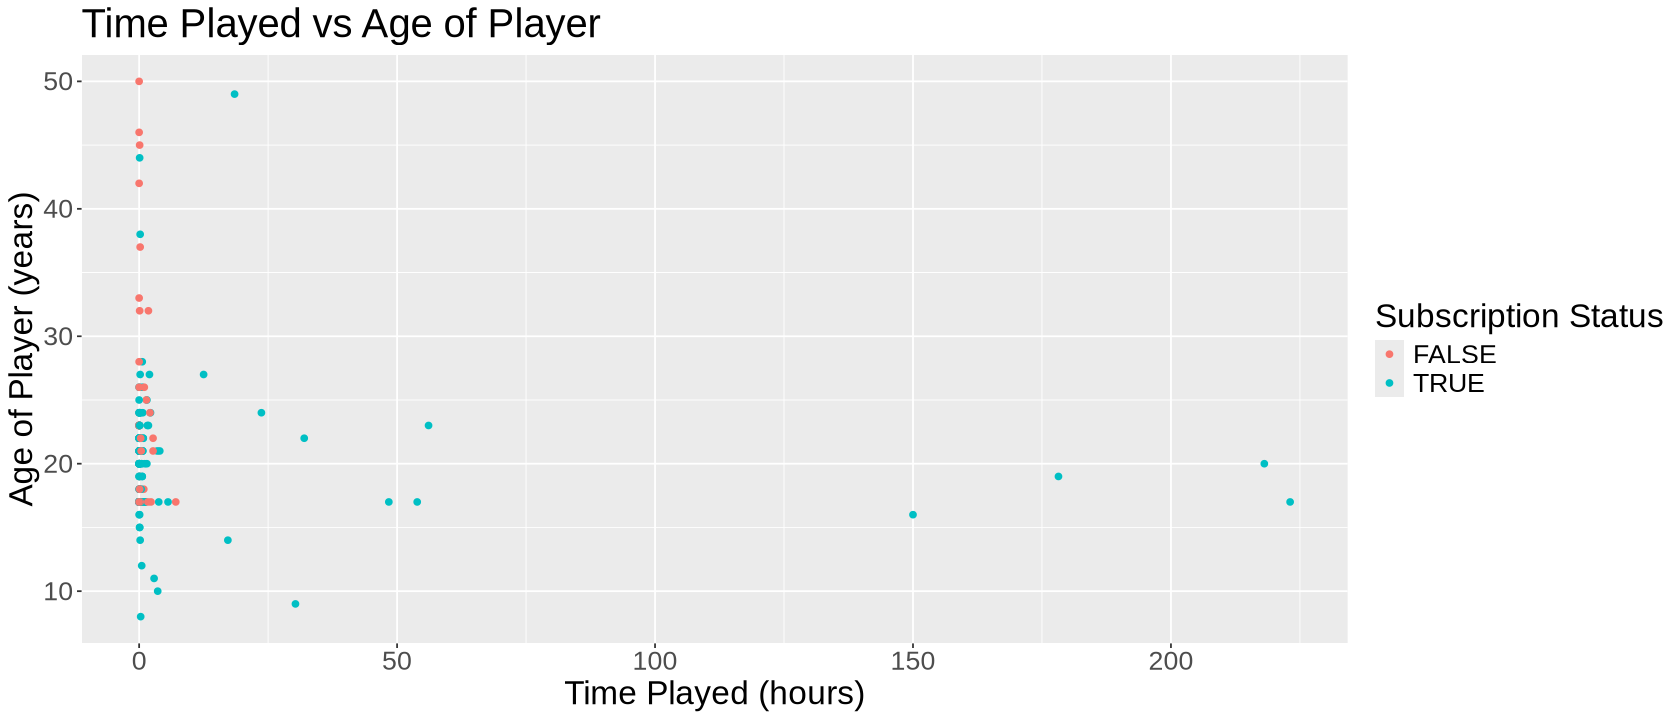

In [6]:
options(repr.plot.width = 14, repr.plot.height = 6)
players_plot <- players_cleaned |>
ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
                       geom_point() +
                       labs(x = "Time Played (hours)", y = "Age of Player (years)", color = "Subscription Status") +
                       ggtitle("Time Played vs Age of Player") +
                       theme(text = element_text(size = 20))

players_plot

Its hard to tell if there is any correlation in this data as the true subscriptions often leak. So, we will need to zoom in on where the majority of the datapoints are. Additionally, it seems that there is way more subscribed than unsubscribed, we will check for that in our following line of code.

subscribe,n
<fct>,<int>
FALSE,52
TRUE,142


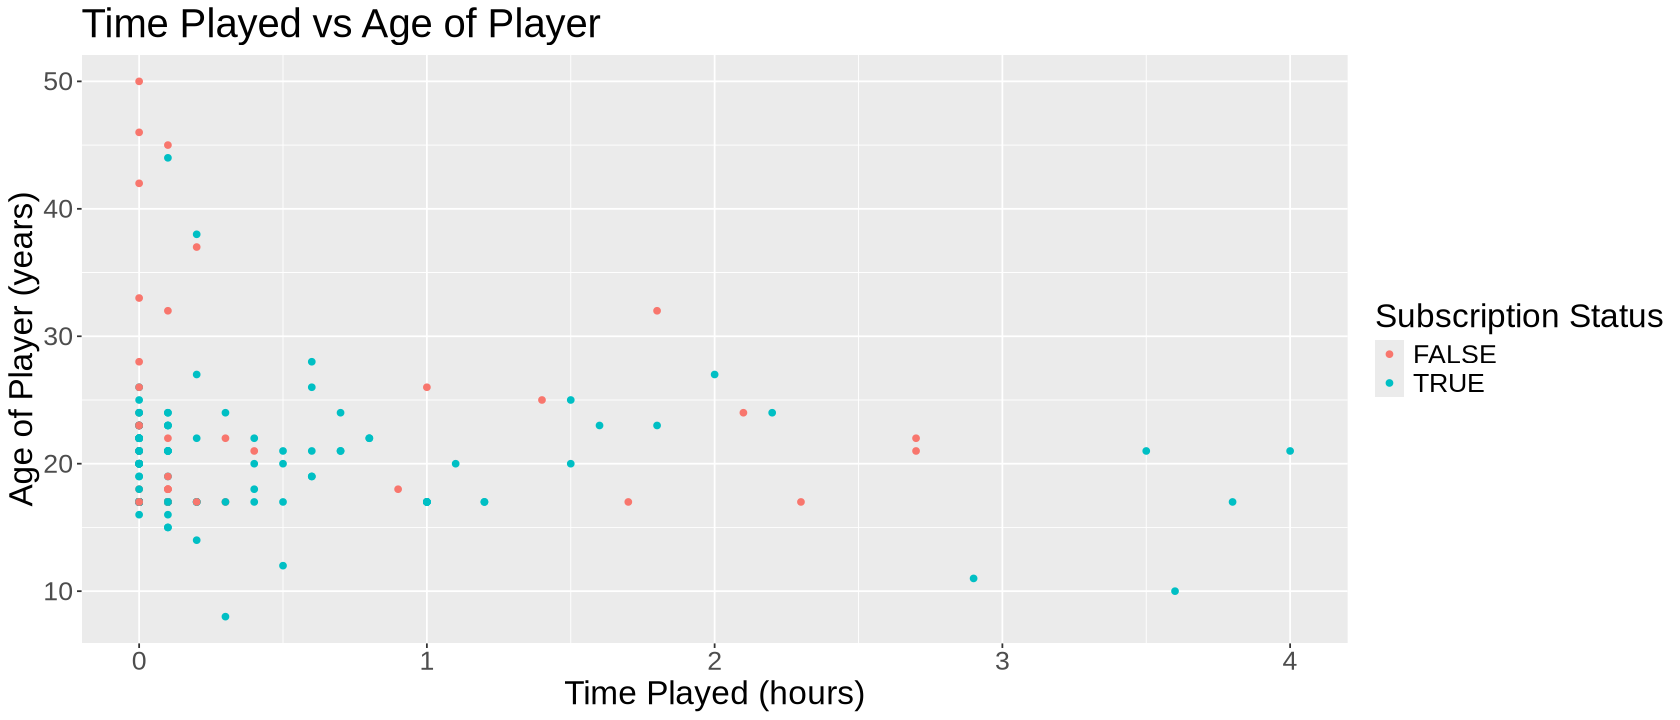

In [7]:
players_plot_shortened <- players_cleaned |>
filter(played_hours < 5) |>
ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
                       geom_point() +
                       labs(x = "Time Played (hours)", y = "Age of Player (years)", color = "Subscription Status") +
                       ggtitle("Time Played vs Age of Player") +
                       theme(text = element_text(size = 20))

players_plot_shortened

players_cleaned %>%
    count(subscribe)

Now we have a clearer view of the majority data points, but it is still hard to see if there is any correlation. It is also apparent now that there is significantly more subscribed than unsubscribed. Hence, a classification model will be used to see how accurate we can classify any new points, and that model will need to be preprocessed first by adding library(themis) to the packages list in the beggining, alongside adding step_upsample in the recipe for balancing.

In [8]:
set.seed(1313) 

players_split <- initial_split(players_cleaned, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

In [9]:
players_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  step_upsample(subscribe)

In [10]:
set.seed(1313)

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

In [11]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [12]:
gridvals <- tibble(neighbors = seq(1, 20))

In [13]:
set.seed(1313)

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

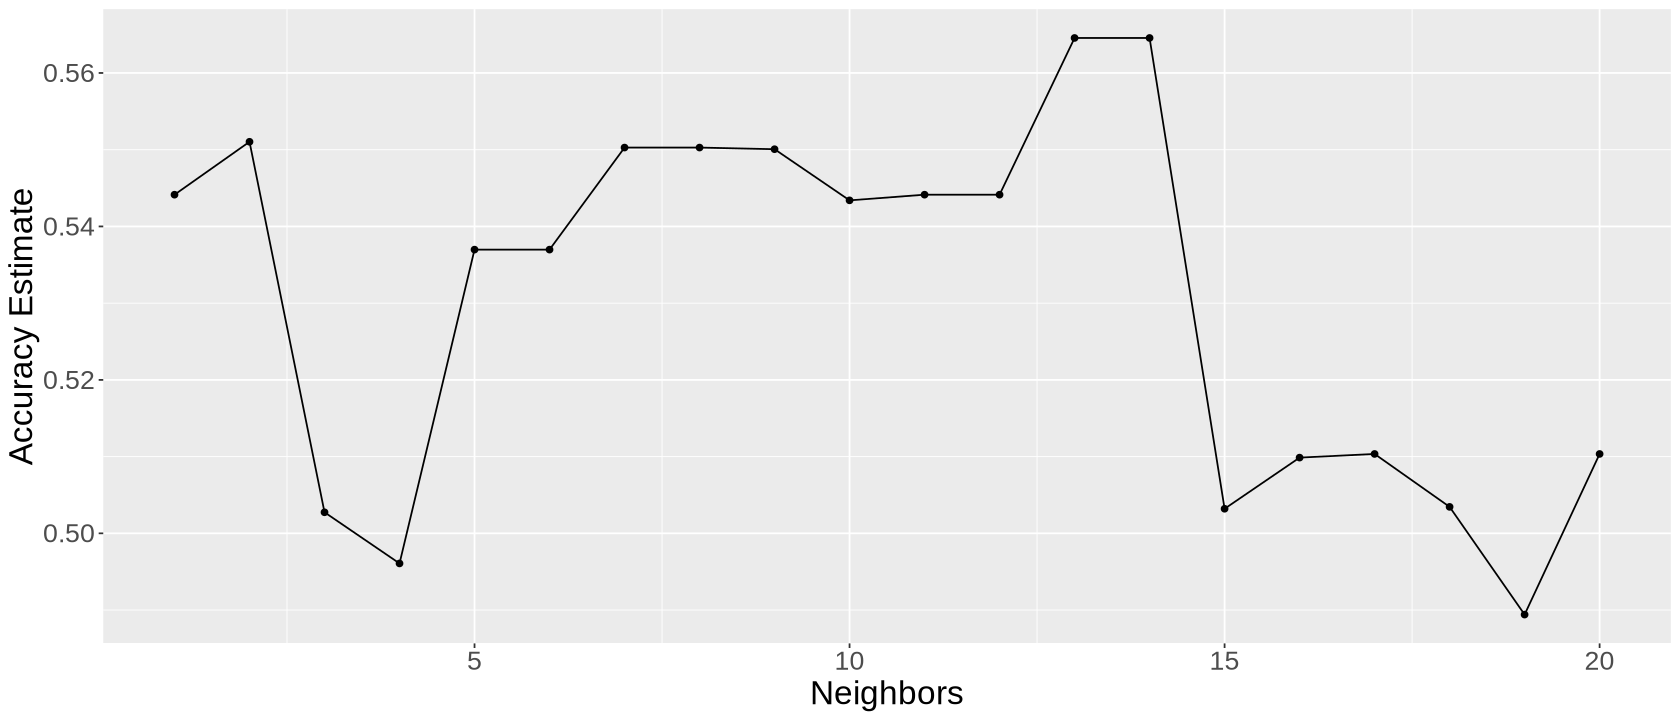

In [14]:
cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot

We can see that the accuracy estimate is the highest when neighbors K = 13 or 14. Hence we use those numbers to find our best model.

In [15]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = players_train)

In [16]:
players_predictions <- predict(players_fit, players_test) |> 
    bind_cols(players_test)

In [17]:
players_acc <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
players_acc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.3469388
kap,binary,-0.1232092


With this, we can see that the accuracy is low and there is minimal correlation.

In [18]:
players_cm <- players_predictions |> 
    conf_mat(truth = subscribe, estimate = .pred_class)
players_cm

          Truth
Prediction FALSE TRUE
     FALSE     7   26
     TRUE      6   10